In [1]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
## This opens a *.pkl file

def unpickle(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

# this saves "thing" to a *.pkl file
def to_pickle(thing, filename):
    with open(filename, "wb") as f:
        pickle.dump(thing, f)
        f.close()

In [5]:
train = unpickle("/content/drive/MyDrive/train.pkl")
print(train["data"].shape)
print(train["label"].shape)

(10000, 12288)
(10000,)


In [6]:
# label dictionary: this maps label integer to the name of the animal
label2name = {1: 'dog',
              2: 'rabbit',
              3: 'deer',
              4: 'elephant',
              5: 'horse',
              6: 'squirrel',
              7: 'tiger',
              8: 'wolf',
              9: 'chimpanzee',
              10: 'panda'}

In [7]:
# this plot one image given the image index
def show_image(idx, train, label2name=label2name):
    img = train["data"][idx]
    img = np.dstack((img[:4096], img[4096:8192], img[8192:])).reshape(64,64,3)
    plt.imshow(img)
    plt.title(label2name[train["label"][idx]])
    plt.show()

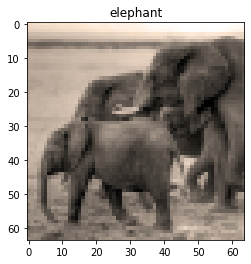

In [8]:
show_image(5, train)

In [9]:
new_thing = type(train["data"])
print(new_thing)
print('shape of one data point')
print(train["data"][0].shape)
print(len(train["data"][0]))
print(train["data"].shape)
#64 x 64 x 3 size array is same shape as 3 color channels from 0-4096

print('one array value')
print(train["data"][0][400])

<class 'numpy.ndarray'>
shape of one data point
(12288,)
12288
(10000, 12288)
one array value
99


In [10]:
#creates a (64, 64, 3) inout array for CNN
def input_cell(idx, train, label2name=label2name):
    img = train["data"][idx]
    img = np.dstack((img[:4096], img[4096:8192], img[8192:])).reshape(64,64,3)
    return img

In [11]:
new_thing_2 = input_cell(5, train)
print(new_thing_2.shape)

print('label value at index[0]')
print(train["label"][5])



y_hot = tf.keras.utils.to_categorical(train["label"])

print(type(y_hot))

(64, 64, 3)
label value at index[0]
4
<class 'numpy.ndarray'>


In [12]:
reshape_list = []
#DO IMAGE AUGMENTATION BEFORE THIS LINE!!!!
train_len = len(train["data"])
#converting train data to array of (10000, 64, 64, 3)
print(train_len)
for i in range(train_len):
  tmp = input_cell(i, train)
  tmp.astype('float32')
  reshape_list.append(tmp)

reshape_array = np.array(reshape_list)

print(reshape_array.shape)
print(reshape_array[0].shape)

10000
(10000, 64, 64, 3)
(64, 64, 3)


In [13]:
reshape_train_normal = (reshape_array / 255)
#print(reshape_train_normal[0])

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import InputLayer, MaxPooling2D, Flatten, Dense, Conv2D, Dropout
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from tensorflow.keras.optimizers import Adam

In [15]:
one_array = np.array(train["data"])
one_array_normal = one_array / 255

In [34]:


y_train = np.asarray(train["label"])
values = np.unique(y_train)
number_labels = len(values)
#print(values)
#print(number_labels)

regular_count_y = []

for i in range(len(y_train)):
  regular_count_y.append(y_train[i]-1)

regular_count_y_array = np.asarray(regular_count_y)



y_train_hot = tf.keras.utils.to_categorical(regular_count_y_array, num_classes=10)
print(y_train_hot.shape)
print(y_train_hot)

(10000, 10)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [158]:
from keras.optimizers import Adagrad

learning_rate = 0.01
epochs = 4000
#opt = tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9)
opt = Adagrad()
weight_ceiling = 1

In [141]:
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2

In [142]:
#book page 461
CNN_book_model = keras.models.Sequential([
    keras.layers.Conv2D(16, 7, activation="relu",input_shape=[64, 64, 3],kernel_initializer='he_normal', kernel_constraint=max_norm(weight_ceiling), bias_constraint=max_norm(weight_ceiling)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(32, 3, activation="relu",kernel_initializer='he_normal', kernel_constraint=max_norm(weight_ceiling), bias_constraint=max_norm(weight_ceiling)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.4),
    #keras.layers.Conv2D(64, 3, activation="relu",kernel_initializer='he_normal', kernel_constraint=max_norm(weight_ceiling), bias_constraint=max_norm(weight_ceiling)),
    #keras.layers.MaxPooling2D(2),
    #keras.layers.Dropout(0.4),
    keras.layers.Flatten(input_shape=[64, 64, 3]),
    keras.layers.Dense(32, activation="relu", kernel_initializer='he_normal', kernel_constraint=max_norm(weight_ceiling), bias_constraint=max_norm(weight_ceiling)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation="relu", kernel_initializer='he_normal', kernel_constraint=max_norm(weight_ceiling), bias_constraint=max_norm(weight_ceiling)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation="softmax", kernel_initializer='he_normal', kernel_constraint=max_norm(weight_ceiling), bias_constraint=max_norm(weight_ceiling))                                
])

In [143]:
CNN_book_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 58, 58, 16)        2368      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 29, 29, 16)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 29, 29, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 27, 27, 32)        4640      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5408)            

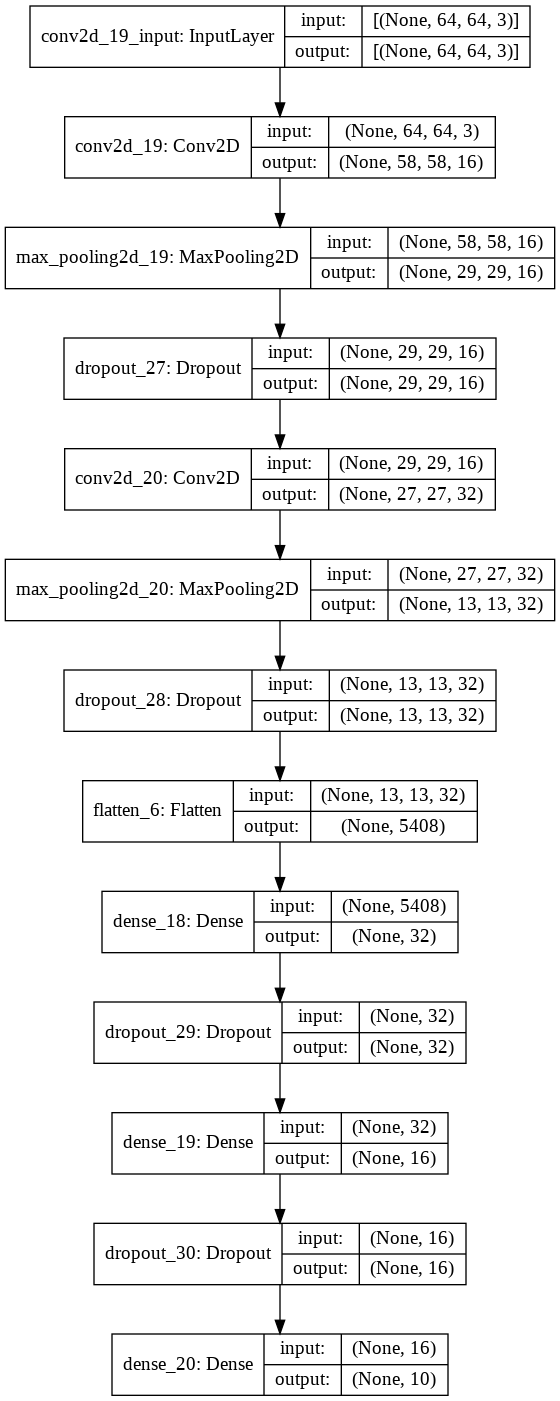

In [144]:
keras.utils.plot_model(CNN_book_model, "my_first_model_with_shape_info.png", show_shapes=True)

In [145]:
CNN_book_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [159]:
#CNN_book_history = CNN_book_model.fit(reshape_train_normal, y_train_hot, epochs=epochs)  ###WORKING ORGINAL
CNN_book_history = CNN_book_model.fit(reshape_train_normal, y_train_hot, epochs=epochs, validation_split = 0.2, batch_size=32)

Epoch 1/4000
250/250 [==============================] - 1s 5ms/step - loss: 1.5247 - accuracy: 0.4730 - val_loss: 1.5309 - val_accuracy: 0.4925
Epoch 2/4000
250/250 [==============================] - 1s 5ms/step - loss: 1.5236 - accuracy: 0.4762 - val_loss: 1.5275 - val_accuracy: 0.4915
Epoch 3/4000
250/250 [==============================] - 1s 5ms/step - loss: 1.5315 - accuracy: 0.4712 - val_loss: 1.5265 - val_accuracy: 0.4915
Epoch 4/4000
250/250 [==============================] - 1s 5ms/step - loss: 1.5060 - accuracy: 0.4881 - val_loss: 1.5269 - val_accuracy: 0.4920
Epoch 5/4000
250/250 [==============================] - 1s 5ms/step - loss: 1.5240 - accuracy: 0.4730 - val_loss: 1.5274 - val_accuracy: 0.4915
Epoch 6/4000
250/250 [==============================] - 1s 5ms/step - loss: 1.5115 - accuracy: 0.4762 - val_loss: 1.5274 - val_accuracy: 0.4925
Epoch 7/4000
250/250 [==============================] - 1s 5ms/step - loss: 1.5242 - accuracy: 0.4700 - val_loss: 1.5259 - val_accuracy:

KeyboardInterrupt: ignored

In [147]:
#getting test data
test = unpickle("/content/drive/MyDrive/test.pkl")
test_data = np.array(test["data"])

In [148]:
#reshape from (, 10000) to (10000, 64, 64, 3)
b = test_data.copy()
print(b.shape)
reshape_test_data = np.reshape(b, (-1, 64, 64, 3))
print(reshape_test_data.shape)

(2000, 12288)
(2000, 64, 64, 3)


In [149]:
#normalize and change to float 32 for training
normal_test_reshape = reshape_test_data / 255
normal_test_reshape.astype('float32')
print(normal_test_reshape.shape)
#print(normal_test_reshape[0])

(2000, 64, 64, 3)


In [150]:
test_image_val = 301

In [151]:
y_pred = CNN_book_model.predict(normal_test_reshape)
print(y_pred[test_image_val])
zero_max_index = np.argmax(y_pred[test_image_val]) + 1
print(zero_max_index)

[0.03394337 0.28105462 0.13877143 0.02668291 0.04815461 0.158825
 0.20200787 0.07867432 0.019728   0.01215793]
2


In [152]:
# this plot one image given the image index
def show_test_image(idx, test):
    img = test["data"][idx]
    img = np.dstack((img[:4096], img[4096:8192], img[8192:])).reshape(64,64,3)
    plt.imshow(img)
    plt.show()

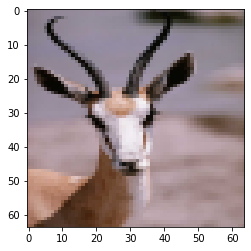

In [153]:
show_test_image(test_image_val, test)

In [154]:
#ghetto y_pred to csv
test_len = len(test["data"])
data_list = []
for i in range(test_len):
  max_index = np.argmax(y_pred[i]) + 1
  tmp_tuple = (i, max_index)
  data_list.append(tmp_tuple)

df = pd.DataFrame(data_list, columns =['id', 'label'])
print(df)

        id  label
0        0      7
1        1      7
2        2      2
3        3      2
4        4      7
...    ...    ...
1995  1995      4
1996  1996      9
1997  1997     10
1998  1998      7
1999  1999      7

[2000 rows x 2 columns]


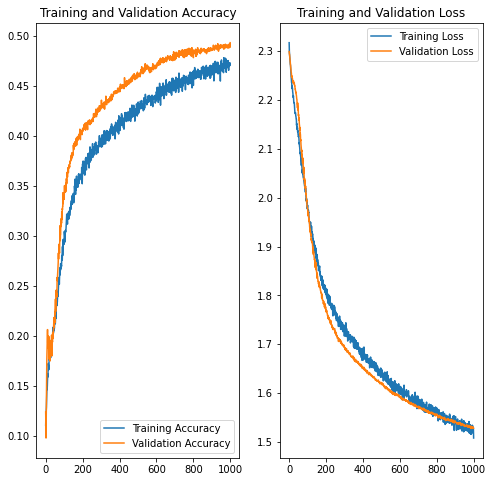

In [155]:
acc = CNN_book_history.history['accuracy']
val_acc = CNN_book_history.history['val_accuracy']

loss = CNN_book_history.history['loss']
val_loss = CNN_book_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [156]:
df.to_csv(path_or_buf='submission.csv',index=False)

In [157]:
del df
del data_list